# HHL code

In [2]:
!pip install qiskit
!pip install pylatexenc
!pip install 'qiskit[visualization]'
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=6a11304f0d8b97708df7a32d5d15c833946271e339ee31b7c9771822af918f37
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.2 MB/s eta 0:00:00


In [4]:
from Generate_Problem_2 import generate_problem

# Third-party libraries
import numpy as np
import pandas as pd
import math
from numpy import linalg as LA

# Qiskit imports
import qiskit
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Initialize, RYGate, HamiltonianGate, QFT

In [5]:
def hhl_circuit(A, b, t0=2*np.pi):  # get hhl circuit
    """
    A: The matrix representing the linear system.
    b: The vector representing the right-hand side of the linear system.
    t: A time parameter used in the controlled-Hamiltonian operations.
    r: A parameter used to determine the rotation angles for the ancilla qubit.
    shots: The number of shots (repetitions) for the quantum circuit execution.

    Returns:
    QuantumCircuit: The quantum circuit for solving the linear system using HHL.
    """
    # ==========================================================================
    # Preprocessing
    # ==========================================================================

    # Check the hermitian matrix
    def check_hermitian(mat):
        mat = np.asarray(mat)
        assert np.allclose(mat, mat.T.conjugate(), rtol=1e-05, atol=1e-08), \
            "Sorry! The input matrix should be Hermitian."
    check_hermitian(A)

    # Normalize A and b
    A = A / LA.norm(b)
    b = b / LA.norm(b)

    # Calculate condition number and eigenvalues of A
    eigs = LA.eigvals(A)
    # ==========================================================================
    # Quantum Circuit
    # ==========================================================================

    # Qubit registers
    ancilla_qbit    = QuantumRegister(1,name='anc')
    q_reg           = QuantumRegister(len(b),name='q') #change to log2
    b_reg           = QuantumRegister(int(math.log2(len(b))),name='b')
    ancilla_result  = ClassicalRegister(1,name='anc_result')
    b_vec           = ClassicalRegister(int(math.log2(len(b))),name='b_vec')
    num_qubits      = len(q_reg) + len(b_reg) + 1

    # Define empty circuit
    circ = QuantumCircuit(ancilla_qbit, q_reg, b_reg, ancilla_result, b_vec,
                          name=f"HHL {len(b)} by {len(b)}")

    # Encode vector b
    init = Initialize(list(b))
    circ.append(init, b_reg)

    # ===========================================================================
    circ.barrier()
    # Hadamard
    circ.h(q_reg)

    # ================================================================================================
    circ.barrier()
    # Apply controlled-Hamiltonian operators on register b
    for i in range(len(q_reg)):
        time = t0/(2**(len(q_reg)-i))
        U = HamiltonianGate(A, time)
        G = U.control(1)
        qubit = [i+1]+[len(q_reg)+j+1 for j in range(int(math.log2(len(b))))]
        circ.append(G, qubit)
        # circ.G(c_reg[i], b_reg[0]) #might need to use .append instead of circ.G to this doesn't work
        # Ramin's code: qubit = [i+1]+[c_num+j+1 for j in range(b_num)]

    # ================================================================================================
    circ.barrier()
    # IQFT
    iqft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=True,
               name='IQFT')
    circ.append(iqft, q_reg)

    # ================================================================================================
    circ.barrier()

    for i in range(len(q_reg)+1):
        if i != 0:
            U = RYGate((2*np.pi)/eigs[i-1]).control(1)  # or 2**(len(q_reg)+1-i) factor?
            circ.append(U, [i, 0])

    # ================================================================================================
    # Uncompute
    # ================================================================================================
    circ.barrier()

    # Measure ancilla qubit
    circ.measure(ancilla_qbit, ancilla_result)

    # ================================================================================================
    circ.barrier()

    # QFT
    qft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=False,
              name='QFT')
    circ.append(qft, q_reg)

    # ================================================================================================
    circ.barrier()
    # Inverse controlled-Hamiltonian operators on register b
    for i in range(len(q_reg))[::-1]:
        time = t0/(2**(len(q_reg)-i))
        U = HamiltonianGate(A, -time)
        G = U.control(1)
        qubit = [i+1]+[len(q_reg)+j+1 for j in range(int(math.log2(len(b))))]
        circ.append(G, qubit)

    # ================================================================================================
    circ.barrier()
    # Hadamards
    circ.h(q_reg)

    # ================================================================================================
    circ.barrier()
    # Measure b
    circ.measure(b_reg, b_vec)

    return circ

In [6]:
from qiskit import transpile
from qiskit_aer import AerSimulator


def quantum_linear_solver(A, b, backend, t0=2*np.pi, shots=1024):  # run hhl circuit on a quantum backend and post-process the result
    """
    Run the hhl circuit on a quantinuum backend and return the result and the compiled circuit.
    Returns:
    The post-processed result of the quantum linear solver (x), and a whole bunch of stats about the circuit.
    """

    csol = np.linalg.solve(A / LA.norm(b), b / LA.norm(b))
    solution = {}

    hhl_circ = hhl_circuit(A, b, t0)
    # transpile in qiskit then convert to a tket circuit if backend is from quantinuum
    qiskit_circuit = transpile(hhl_circ, AerSimulator())

    if isinstance(backend, AerSimulator):
         #print(f"Running on {backend.name}")
         qiskit_circuit = transpile(hhl_circ, backend, optimization_level=3)
         solution['number_of_qubits'] = qiskit_circuit.num_qubits
         solution['circuit_depth'] = qiskit_circuit.depth()
         solution['total_gates'] = qiskit_circuit.size()
         solution['cost'] = 0
         job = backend.run(qiskit_circuit, shots=shots)
         result = job.result()

    def process_result(result):  # process the result of the quantum linear solver and return the solution vector
        """
        Process the result of the quantum linear solver and return the solution vector.
        """
        # Get the counts
        counts = result.get_counts()

        def solution_vector(counts, b):
            b_num = int(math.log2(len(b)))
            num = 0  # for normalization
            app_sol = np.zeros(2 ** b_num)

            if isinstance(backend, AerSimulator):
                for key, value in counts.items():
                    if key[-1] == '1':
                        num += value
                        cord = int(key[:b_num], base=2)  # position in b vector from binary string
                        app_sol[cord] = value
                if num == 0:
                    return app_sol
                app_sol = np.sqrt(app_sol/num)
                # app_sol = app_sol/num
                return app_sol

            else:
                for key, value in counts.items():
                    key_str = "".join(str(bit) for bit in key)
                    if key_str[-1] == '1':
                        num += value
                        cord = int(key_str[:b_num], base=2)
                        app_sol[cord] = value
                if num == 0:
                    return app_sol
                app_sol = np.sqrt(app_sol/num)
                # app_sol = app_sol/num
                return app_sol

        # Extract approximate solution
        qsol = solution_vector(counts, b)

        # Avoiding sign estimation for now
        for idx, (i, j) in enumerate(zip(csol, qsol)):
            if i < 0:
                qsol[idx] = -j
        return qsol

    x = process_result(result)
    solution['x'] = x

    two_norm_error = LA.norm(csol - x)
    solution['two_norm_error'] = two_norm_error

    residual_error = LA.norm(b - A @ x) #normalize as in hhl?
    solution['residual_error'] = residual_error

    return solution

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm
import itertools
from qiskit_aer import AerSimulator


# Iterative Refinement
def norm_estimation(A, b, x):
    # this function finds scaling factor alpha such that alpha = argmin ||A alpha x - b||_2^2
    v = A @ x
    denominator = np.dot(v, v)
    if denominator == 0:
        # This means v is a zero vector, so we can't compute alpha as intended.
        # You might choose to handle this special case differently:
        # For example, if v is zero, alpha doesn't matter since A*x = 0.
        # Maybe return alpha = 0 or raise an error.
        alpha = 1e-5
        return alpha
    alpha = (np.dot(v, b)) / denominator
    return alpha


def sign_estimation(A, b, x):
    # this function finds solution z such that alpha = argmin ||A z - b||_2^2 and |z|=|x|
    n = len(x)
    matrix = []
    for bits in itertools.product([-1, 1], repeat=n):
        if any(column == list(bits) for column in matrix):
            continue
        matrix.append(list(bits))
    z = np.zeros(n)
    mins = np.infty
    for i in range(len(matrix)):
        t = np.linalg.norm(A@np.multiply(matrix[i], x) - b)
        if t < mins:
            mins = t
            z = np.multiply(matrix[i], x)
    return z


def IR(A, b, precision, max_iter, backend, plot=False, shots = 1024):
    # Scaled Iterative Refinement for solving a linear system
    nabla             = 1                             # Scaling factor
    rho               = 2                             # Incremental scaling
    d                 = len(A)                        # Dimension
    iteration         = 1                             # Iteration counter
    x                 = np.zeros(d)                   # Solution
    r                 = b                             # Residual
    con               = np.linalg.cond(A)             # Condition number
    cost              = 0                             # Cost of credits
    csol              = solve(A, b)                   # Classical solution
    res_list=[]
    error_list=[]

    while (norm(r) > precision and iteration <= max_iter):
        #print("Iteration:", iteration)
        new_r = nabla*r
        result = quantum_linear_solver(A, new_r, backend=backend, t0=2*np.pi, shots=shots)
        cost += result['cost']
        c = result['x']
        alpha = norm_estimation(A, new_r, c)            # Calculating best norm estimation
        x = x + (alpha/nabla)*c                         # Updating solution
        err = norm(csol - x)
        error_list.append(err)
        r = b - np.dot(A, x)
        res = norm(r)
        if alpha == 0:
            res_list.append(res)
            #print("residual:", res)
            #print("error:", err)
            #print("Alpha is zero, stopping iteration.")
            break
        if res == 0:
            # print("Residual norm is too small, stopping iteration.")
            # res_list.append(res)
            # break
            #print("Residual norm is zero!")
            nabla = rho*nabla
        else:
            nabla = min(rho*nabla, 1/(res))  # Updating scaling factor
        # print("Nabla", nabla)
        res_list.append(res)
       # print("residual:", res)
        #print("error:", err)
       # print("alpha:", alpha)
        iteration+=1
        # print("Precision:",LA.norm((res - A*c*alpha)))
       # print()

    result = {}
    result['refined_x'] = x
    result['residuals'] = res_list
    result['errors'] = error_list
    result['total_iterations'] = iteration - 1
    result['total_cost'] = cost

    if plot:
        plt.plot(np.array(range(len(res_list))), [np.log10(res_list[i]) for i in range(len(res_list))],'o--',
                 label=f'HHL with IR on {backend.name if isinstance(backend, AerSimulator) else backend.backend_config.device_name}')
        plt.ylabel(r"$\log_{10}(\|Ax-b\|_2)$")
        plt.xlabel("IR Iteration")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.plot(np.array(range(len(error_list))), [np.log10(error_list[i]) for i in range(len(error_list))], 'o--', label=f'HHL with IR on {backend.name if isinstance(backend, AerSimulator) else backend.backend_config.device_name}')
        plt.ylabel(r"$\log_{10}(\|x-x_{\mathrm{classical}}\|_2)$")
        plt.xlabel("IR Iteration")
        plt.legend()
        plt.tight_layout()
        plt.show()
    return result

In [8]:
import pandas as pd
import numpy as np
from qiskit_aer import AerSimulator

def generate_quantum_solver_results(
    problem_sizes=[2, 4, 8],
    condition_numbers=[1, 5, 10, 100, 500, 1000],
    sparsity=1,
    is_diagonal=False,
    is_positive = False,
    integer_elements=False,
    precision=1e-5,
    max_iter=5,
    t0=2 * np.pi,
    shots=1024,
    include_full_data=False,
    Type = "None"
):
    """
    Generates a DataFrame of quantum solver results over multiple problem sizes and condition numbers.

    Parameters:
    - problem_sizes: list of integers
    - condition_numbers: list of floats
    - include_full_data: if True, keeps A, b, error/residual lists in final DataFrame

    Returns:
    - df: pandas DataFrame of raw data
    - df_display: cleaned DataFrame for display
    """
    backend = AerSimulator()
    df = pd.DataFrame()

    for k in problem_sizes:
        for i in condition_numbers:
            problem = generate_problem(
                n=k,
                cond_number=i,
                sparsity=sparsity,
                is_diagonal=is_diagonal,
                is_positive=is_positive,
                integer_elements=integer_elements
            )
            A = problem['A']
            b = problem['b']
            solution = quantum_linear_solver(A, b, backend=backend, t0=t0, shots=shots)

            # Iterative Refinement
            refined_solution = IR(A, b, precision=precision, max_iter=max_iter, backend=backend, plot=False)

            datarow = {
                "Backend": backend.name,
                "Problem Size": f"{len(b)} x {len(b)}",
                "A": A,
                "Type": Type,
                "b": b,
                "Condition Number": problem["condition_number"],
                "Sparsity": problem["sparsity"],
                "Number of Qubits": solution["number_of_qubits"],
                "Circuit Depth": solution["circuit_depth"],
                "Total Gates": solution["total_gates"],
                # "Two-Qubit Gates": solution.get("two_qubit_gates"),
                # "Runtime": solution.get("runtime"),
                "||x_c - x_q|| without IR": solution["two_norm_error"],
                "||x_c - x_q|| with IR": refined_solution["errors"][-1],
                "||Ax - b|| without IR": solution["residual_error"],
                "||Ax - b|| with IR": refined_solution["residuals"][-1],
                "Total Iterations of IR": refined_solution["total_iterations"],
                "Error list": refined_solution["errors"],
                "Residual list": refined_solution["residuals"],
            }

            df = pd.concat([df, pd.DataFrame([datarow])], ignore_index=True)

    # Drop large columns for display
    if include_full_data:
        df_display = df.copy()
    else:
        df_display = df.drop(columns=["Error list", "Residual list", "A", "b"])

    return df, df_display

In [17]:
def residual_vs_shots_plot(A, b, shot_range, max_iter=5):
    backend = AerSimulator()
    classical_solution = np.linalg.solve(A, b)

    residuals_hhl = []
    residuals_ir = []

    for shots in shot_range:
        # HHL only
        result_hhl = quantum_linear_solver(A, b, backend=backend, shots=shots)
        res_hhl = result_hhl['residual_error']
        x = result_hhl['x']
        print(x, res_hhl)
        residuals_hhl.append(res_hhl)

        # HHL + IR
        result_ir = IR(A, b, precision=1e-5, max_iter=max_iter, backend=backend, shots=shots/10)
        res_ir = result_ir['residuals'][-1]
        print(result_ir['refined_x'], res_ir)
        residuals_ir.append(res_ir)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(shot_range, residuals_hhl, 'o-', label='HHL only')
    plt.plot(shot_range, residuals_ir, 's--', label=f'HHL + IR ({max_iter} iterations)')
    plt.xlabel("Number of shots")
    plt.ylabel(r"Residual $\|Ax - b\|_2$")
    plt.title("Residual vs Number of Shots")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Residuals plots

/tmp/ipython-input-5-2842859898.py:69: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=True,
/tmp/ipython-input-5-2842859898.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=False,


[-0.5         0.70710678  0.         -0.5       ] 0.39080277325645996
[0. 0. 0. 0.] 0.19914132050313066
[-0.57735027  0.33333333  0.57735027 -0.47140452] 0.34775074260055155
[-0.12545318  0.          0.          0.0040846 ] 0.17766597804538978
[-0.45643546  0.28867513  0.73598007 -0.40824829] 0.2910659043901531
[-0.09020393  0.08534337  0.24346803 -0.12069375] 0.10271627343897781
[-0.58630197  0.30618622  0.6846532  -0.30618622] 0.364630386984743
[-0.13920513  0.24485902  0.42943915 -0.29360086] 0.0791184868296107
[-0.6094494   0.37796447  0.47809144 -0.50709255] 0.3715048731605535
[-0.07580793  0.07580793  0.30672145 -0.10312401] 0.10274722193718357
[-0.49487166  0.24743583  0.71428571 -0.42857143] 0.3104527394591437
[-0.13965231  0.31349808  0.34422548 -0.17384577] 0.06526520947992394
[-0.45993311  0.39223227  0.65044364 -0.45993311] 0.27641807445451
[-0.12561648  0.93783978  0.3619135  -0.20777156] 0.00019432045146921336
[-0.51946248  0.33333333  0.66666667 -0.41785545] 0.3157428549

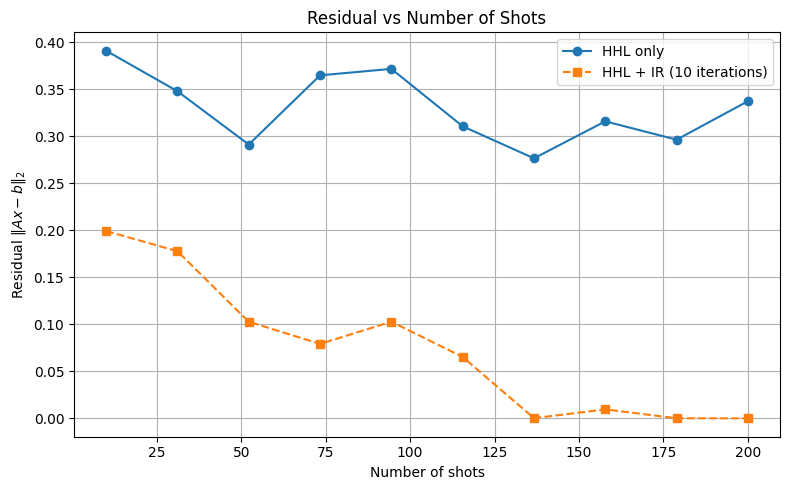

In [18]:
#problem = generate_problem(n=4, cond_number=10)
A = problem["A"]
b = problem["b"]

residual_vs_shots_plot(A, b, shot_range=np.linspace(10, 200, num=10), max_iter=10)

In [13]:
backend = AerSimulator()
result_hhl = quantum_linear_solver(A, b, backend=backend, shots=10)
print(result_hhl['x'])

/tmp/ipython-input-5-2842859898.py:69: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=True,
/tmp/ipython-input-5-2842859898.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=False,


[-0.5         0.          0.5        -0.70710678]


In [11]:
csol = LA.solve(A,b)
csol

array([-0.12545318,  0.93783978,  0.36226188, -0.20785721])

In [ ]:
def residual_vs_ir(A, b, max_iter_range=range(1, 11), shots=1024):
    backend = AerSimulator()
    all_residuals = []

    for max_iter in max_iter_range:
        result = IR(A, b, precision=1e-5, max_iter=max_iter, backend=backend, shots=shots)
        residuals = result["residuals"]
        all_residuals.append(residuals)

    # Plotting
    plt.figure(figsize=(8, 5))
    for i, res in enumerate(all_residuals):
        plt.plot(range(1, len(res)+1), np.log10(res), '--o', label=f'{i+1} IR iters')

    plt.xlabel("IR Iteration")
    plt.ylabel(r"$\log_{10}(\|Ax - b\|)$")
    plt.title("Residual vs IR Iterations (Same Problem)")
    plt.grid(True)
    plt.legend(title="Max IR Iterations Allowed")
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-4-1539466102.py:69: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=True,
/tmp/ipython-input-4-1539466102.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=False,


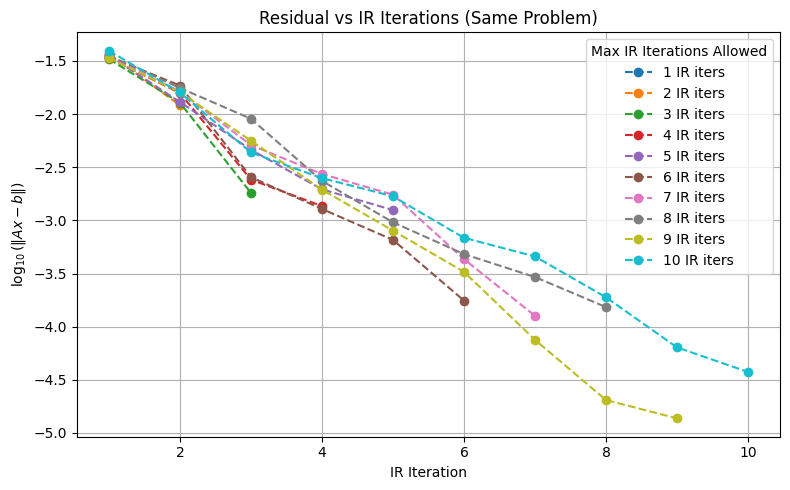

In [ ]:
problem = generate_problem(n=4, cond_number=10)
A = problem["A"]
b = problem["b"]

residual_vs_ir(A, b, max_iter_range=range(1, 11), shots=1024)

### Diagonal matrix

A:  [[0.07761505 0.         0.         0.        ]
 [0.         0.31046021 0.         0.        ]
 [0.         0.         0.54330537 0.        ]
 [0.         0.         0.         0.77615053]]
b:  [-0.02483682  0.04889748 -0.02794142  0.03337447]


/tmp/ipython-input-4-1539466102.py:69: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=True,
/tmp/ipython-input-4-1539466102.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=False,


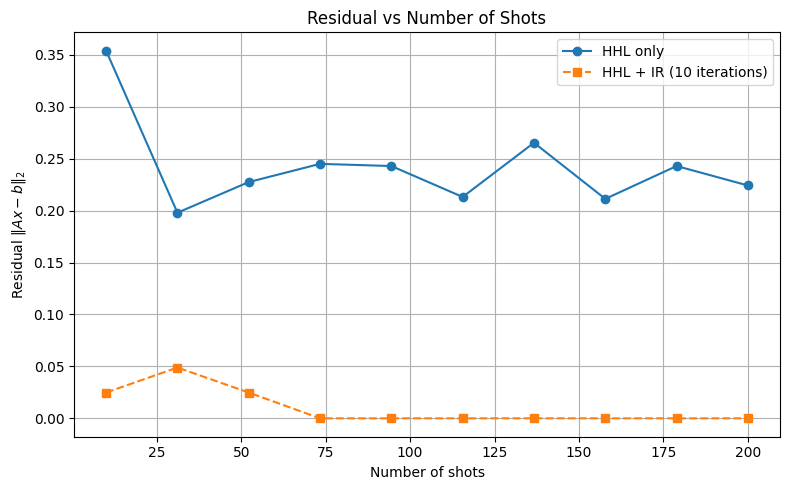

In [ ]:
problem = generate_problem(n=4, cond_number=10, is_diagonal = True)
A = problem["A"]
b = problem["b"]
print("A: ", A)
print("b: ", b)

residual_vs_shots_plot(A, b, shot_range=np.linspace(10, 200, num=10), max_iter=10)

### Nonzero result

A:  [[ 0.20698471 -0.          0.15425556 -0.02722318]
 [-0.          0.51959607  0.         -0.        ]
 [ 0.15425556  0.          0.60160394  0.        ]
 [-0.02722318 -0.          0.          0.52552659]]
b:  [0.26096016 0.10991516 0.68389402 0.32265973]


/tmp/ipython-input-4-1539466102.py:69: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=True,
/tmp/ipython-input-4-1539466102.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(len(q_reg), approximation_degree=0, do_swaps=True, inverse=False,


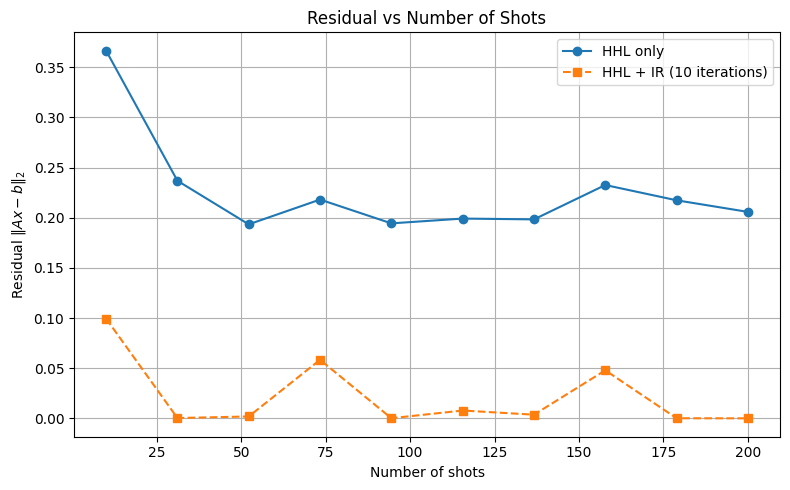

In [ ]:
problem = generate_problem(n=4, cond_number=10, is_positive = True)
A = problem["A"]
b = problem["b"]
print("A: ", A)
print("b: ", b)

residual_vs_shots_plot(A, b, shot_range=np.linspace(10, 200, num=10), max_iter=10)